# Лабораторная работа 1. Классические методы построения рекомендаций.

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit.

Вопросы по заданию можно писать в чат курса или на почту, которая будет дана в чате курса. Ссылка на форму для отправки решений будет дана в чате.

In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from copy import deepcopy
from scipy.sparse import csr_matrix
from implicit.nearest_neighbours import CosineRecommender, bm25_weight
from implicit.als import AlternatingLeastSquares
from rs_datasets import MovieLens

In [275]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [276]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [277]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [278]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(1)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40


In [279]:
get_log_info(reviews)

Длина лога = 1000209,
количество пользователей = 6040,
количество объектов = 3706


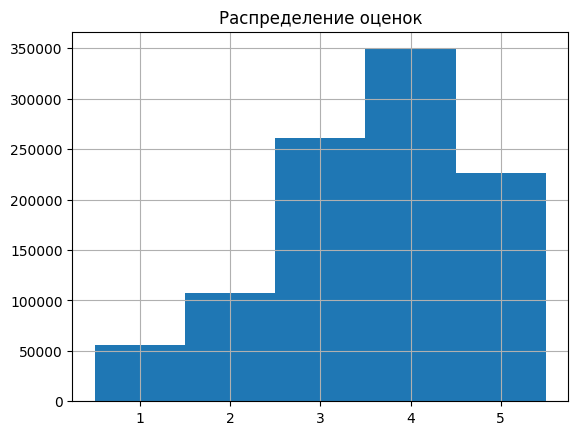

In [280]:
plt.hist(reviews['relevance'], bins=np.arange(0.5,6,1))
plt.title("Распределение оценок")
plt.grid()
plt.show()

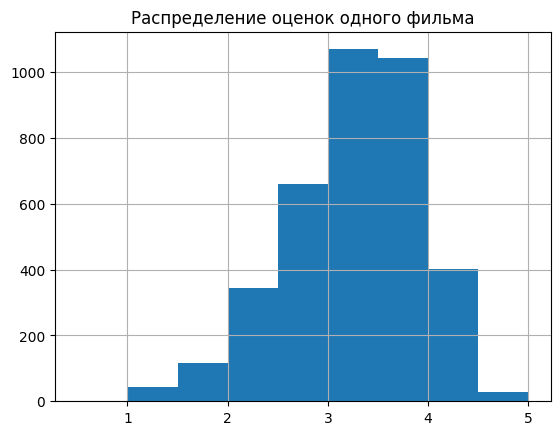

In [281]:
plt.hist(reviews.groupby(['item_id'])['relevance'].mean(), bins=np.arange(0.5,5.5,0.5))
plt.title("Распределение оценок одного фильма")
plt.grid()
plt.show()

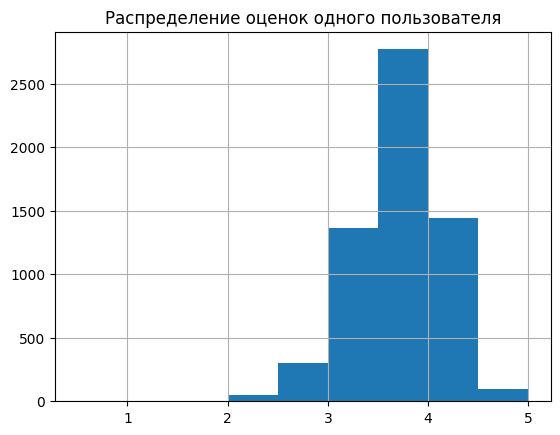

In [282]:
plt.hist(reviews.groupby(['user_id'])['relevance'].mean(), bins=np.arange(0.5,5.5,0.5))
plt.title("Распределение оценок одного пользователя")
plt.grid()
plt.show()

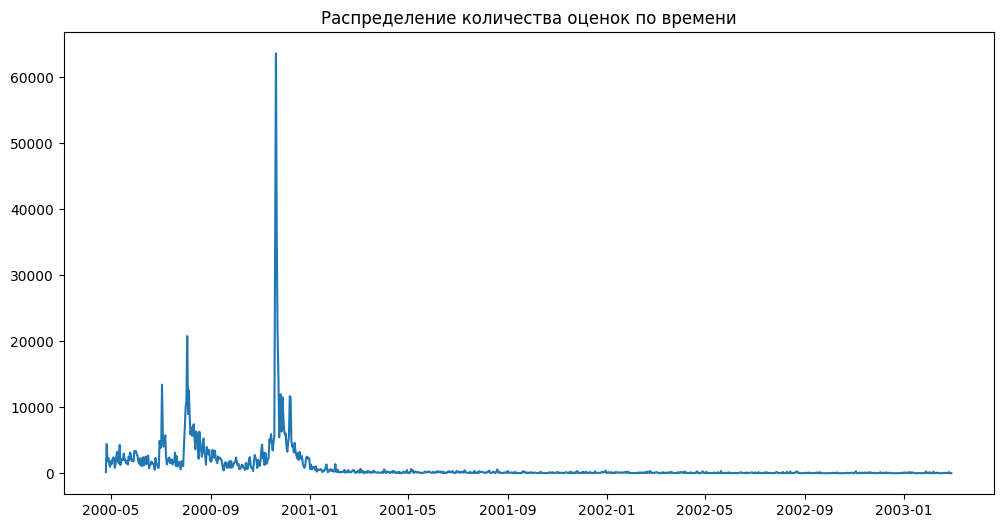

In [283]:
plt.figure(figsize=(12,6))
plt.plot(reviews.groupby(reviews['timestamp'].dt.date)['relevance'].count())
plt.title("Распределение количества оценок по времени")
plt.show()

Как мы видим, средняя оценка одного фильма около 3.5, а средняя оценка одного пользователя около 3.7, а пик активности приходится на конец 2000 года.

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

In [390]:
train = reviews[reviews['timestamp'] < '2000-12-01']
val = reviews[(reviews['timestamp'] >= '2000-12-01') & (reviews['timestamp'] <= '2000-12-31') & (reviews['relevance'] > 3)]
cold_guys = set(val['user_id']) - set(train['user_id'])
val = val[~val['user_id'].isin(cold_guys)]
val = val[['user_id', 'item_id', 'relevance']]
train = train[['user_id', 'item_id', 'relevance']]

In [285]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

In [286]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [287]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [288]:
%%time
random_pred = []
for user_id in val['user_id'].unique():
    recommended_items = np.random.choice(reviews['item_id'].unique(), size=K, replace=False)
    for item in recommended_items:
        random_pred.append((user_id, item, np.random.randint(5) + 1))

# создадим DataFrame с рекомендациями
columns = ['user_id', 'item_id', 'relevance']
random_pred = pd.DataFrame(random_pred, columns=columns)

CPU times: user 4.39 s, sys: 20.6 ms, total: 4.41 s
Wall time: 4.53 s


In [289]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [290]:
random_pred.head(1)

,user_id,item_id,relevance
0,670,1750,1


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [291]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    pred_list = row['pred_list'][:k]
    gt_list = row['gt_list']

    if len(gt_list) == 0:
        return 0

    idcg = sum([1 / math.log2(j + 1) for j in range(1, min(k, len(gt_list)) + 1)])

    dcg = 0
    for j, item in enumerate(pred_list):
        if item in gt_list:
            dcg += 1 / math.log2(j + 1 + 1)

    return dcg / idcg

In [292]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [293]:
def ndcg_all(row, k=K):

    ndcg_all = 0
    for i in range(row.shape[0]):
        ndcg_all += ndcg_user(row.iloc[i], k)

    return ndcg_all/row.shape[0]

### Surprisal
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [294]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        self.log = log

    def __call__(self, pred, k):

        res = 0
        for item in set(pred['item_id']):
            res += self.selfInformation(item)

        return res / (k * math.log2(len(pd.unique(self.log['user_id']))) * len(pd.unique(pred['user_id'])))

    def selfInformation(self, item):
        if item in pd.unique(self.log['item_id']):
            u_i = self.log[self.log['item_id'] == item].shape[0]
        else:
            u_i = 1
        return - math.log2(u_i / len(pd.unique(self.log['user_id'])))

In [295]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

In [296]:
def user_hitrate(row, k):

    pred_list = row['pred_list'][:k]
    gt_list = row['gt_list']

    for item in pred_list:
        if item in gt_list:
            return 1

    return 0

def hitrate(row, k=K):

    hr_all = 0
    for i in range(row.shape[0]):
        hr_all += user_hitrate(row.iloc[i], k)

    return hr_all / row.shape[0]

In [297]:
def leave_top_k(pred, k):

    if pred.groupby('user_id')['user_id'].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = cropped_pred.groupby('user_id')['relevance'].rank(method="first", ascending=False)
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])

    return cropped_pred

def coverage(pred, k, all_items):
    return len(set(leave_top_k(pred, k)['item_id']) & set(all_items)) / len(all_items)

In [298]:
def evaluate_metrics(pred, val, k=K):

    val = val.sort_values(by=['user_id', 'relevance'], ascending = False)
    list_val = val.groupby('user_id', as_index = False).agg({'item_id': lambda x: list(x), 'relevance': lambda x: list(x)})
    list_val.rename(columns={'item_id': 'gt_list'}, inplace=True)

    pred = pred.sort_values(by=['user_id', 'relevance'], ascending = False)
    list_pred = pred.groupby('user_id', as_index = False).agg({'item_id': lambda x: list(x), 'relevance': lambda x: list(x)})
    list_pred.rename(columns={'item_id': 'pred_list'}, inplace=True)

    row = pd.merge(list_pred[['user_id', 'pred_list']], list_val[['user_id', 'gt_list']], how='right', on='user_id')

    metrics = dict()
    metrics[f'nDCG@{k}'] = ndcg_all(row, k)
    metrics[f'HitRate@{k}'] = hitrate(row, k)
    metrics[f'Coverage@{k}'] = coverage(pred, k, val['item_id'].unique())
    metrics[f'Surprisal@{k}'] = Surprisal(val)(pred, k)

    return metrics

In [299]:
metric_dict = evaluate_metrics(random_pred, val, k=K)
for key, item in metric_dict.items():
    print(f"{key} : {item}")

nDCG@20 : 0.00951959248358902
HitRate@20 : 0.12452107279693486
Coverage@20 : 0.9363519863306279
Surprisal@20 : 0.28984243187747355


## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

In [460]:
train = reviews[reviews['timestamp'] < '2000-12-01']
val = reviews[(reviews['timestamp'] >= '2000-12-01') & (reviews['timestamp'] < '2000-12-15')]
test = reviews[(reviews['timestamp'] >= '2000-12-15') & (reviews['timestamp'] <= '2000-12-31')]
cold_guys_val = set(val['user_id']) - set(train['user_id'])
val = val[~val['user_id'].isin(cold_guys_val)]
cold_guys_test = set(test['user_id']) - set(train['user_id'])
test = test[~test['user_id'].isin(cold_guys_test)]
train = train[['user_id', 'item_id', 'relevance']]
val = val[['user_id', 'item_id', 'relevance']]
test = test[['user_id', 'item_id', 'relevance']]

train['relevance'] = train['relevance'].astype('float32', copy=False)
csr_train = csr_matrix((train['relevance'].values, (train['user_id'].values, train['item_id'].values)))
val['relevance'] = val['relevance'].astype('float32', copy=False)
csr_val = csr_matrix((val['relevance'].values, (val['user_id'].values, val['item_id'].values)))
val['relevance'] = val['relevance'].astype('float32', copy=False)
csr_test = csr_matrix((test['relevance'].values, (test['user_id'].values, test['item_id'].values)))

<ipython-input-460-b289b02810c8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['relevance'] = train['relevance'].astype('float32', copy=False)


In [461]:
%%time

model = CosineRecommender(K=20)
model.fit(csr_train)

cosine_pred = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred = pd.DataFrame(cosine_pred, columns=columns)

metric_dict_cosine = evaluate_metrics(cosine_pred, val, k=K)
print("cosine")
for key, item in metric_dict_cosine.items():
    print(f"{key} : {item}")

print()

random_pred = []
for user_id in val['user_id'].unique():
    recommended_items = np.random.choice(reviews['item_id'].unique(), size=K, replace=False)
    for item in recommended_items:
        random_pred.append((user_id, item, np.random.randint(5) + 1))

columns = ['user_id', 'item_id', 'relevance']
random_pred = pd.DataFrame(random_pred, columns=columns)

metric_dict = evaluate_metrics(random_pred, val, k=K)
print("random")
for key, item in metric_dict.items():
    print(f"{key} : {item}")

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006514787673950195 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine
nDCG@20 : 0.15238065301186973
HitRate@20 : 0.5177664974619289
Coverage@20 : 0.1408005617977528
Surprisal@20 : 0.027580007688718426

random
nDCG@20 : 0.013946805436868543
HitRate@20 : 0.15736040609137056
Coverage@20 : 0.8872893258426966
Surprisal@20 : 0.33442120042668544
CPU times: user 8.64 s, sys: 34.3 ms, total: 8.68 s
Wall time: 7.99 s


nDCG@20 и HitRate@20 увеличились, а Coverage@20 и Surprisal@20 уменьшились, так как мы стали рекомендовать более узкий набор фильмов.

In [462]:
def cosine_recommendations(neighbours):
    model = CosineRecommender(K=neighbours)
    model.fit(csr_train)

    cosine_pred = []
    for user_id in val["user_id"].unique():
        items, scores = model.recommend(user_id, csr_train[user_id], N=K)
        for item, score in zip(items, scores):
            cosine_pred.append((user_id, item, score))
    columns = ['user_id', 'item_id', 'relevance']
    cosine_pred = pd.DataFrame(cosine_pred, columns=columns)
    return cosine_pred

In [463]:
neighbours = np.arange(1, 51)
nDCG_rate = []
HitRate_rate = []
Coverage_rate = []
Surprisal_rate = []

for neighbour in neighbours:
    cosine_pred = cosine_recommendations(neighbour)
    metrics = evaluate_metrics(cosine_pred, val, k=K)
    nDCG_rate.append(metrics[f'nDCG@{K}'])
    HitRate_rate.append(metrics[f'HitRate@{K}'])
    Coverage_rate.append(metrics[f'Coverage@{K}'])
    Surprisal_rate.append(metrics[f'Surprisal@{K}'])

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0065805912017822266 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006396055221557617 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006632804870605469 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0059702396392822266 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008128166198730469 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006551504135131836 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0074100494384765625 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006594181060791016 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0060498714447021484 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0065081119537353516 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0074427127838134766 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006388187408447266 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005975961685180664 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0065076351165771484 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006392955780029297 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007082223892211914 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00731658935546875 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006524801254272461 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006390094757080078 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00643610954284668 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006791591644287109 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007050275802612305 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008199214935302734 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0064983367919921875 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006310224533081055 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0062198638916015625 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006413936614990234 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0066339969635009766 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0072667598724365234 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006357669830322266 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006485700607299805 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005990028381347656 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006036520004272461 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006381511688232422 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008071184158325195 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0074615478515625 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006574153900146484 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006542682647705078 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006069183349609375 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006608247756958008 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007380247116088867 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0063877105712890625 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006550312042236328 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007013797760009766 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005992889404296875 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00652003288269043 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007996797561645508 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007906198501586914 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005964040756225586 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006477832794189453 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

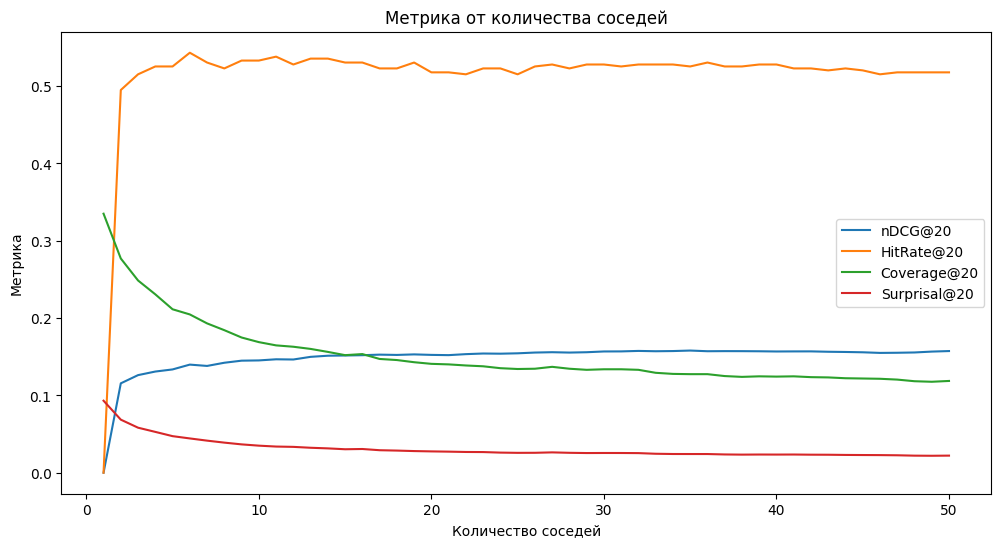

In [464]:
plt.figure(figsize=(12,6))
plt.plot(neighbours, nDCG_rate, label = f'nDCG@{K}')
plt.plot(neighbours, HitRate_rate, label = f'HitRate@{K}')
plt.plot(neighbours, Coverage_rate, label = f'Coverage@{K}')
plt.plot(neighbours, Surprisal_rate, label = f'Surprisal@{K}')
plt.xlabel('Количество соседей')
plt.ylabel('Метрика')
plt.legend()
plt.title('Метрика от количества соседей')
plt.show()

Как мы видим, графики достаточно быстро выходят на плато. nDCG@20 и HitRate@20 увеличиваются, а Coverage@20 и Surprisal@20 уменьшаются с увеличением количества соседей. Первые две метрики растут, так как мы увеличивает качество, вторые две метрики падают, так как мы начинает предлагать более очевилдные варианты. Можно взять количество соседей равное 10.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

Весовая функция bm25 учитывает частоту термина в документе, длину документа и среднюю длину документов в корпусе:
$$
\text{bm25}(D, Q) = \sum_{i = 1}^n \text{IDF}(q_i) \cdot \frac{f(q_1, D) \cdot (k_1 + 1)}{f(q_i, D) + k_1 \cdot (1 - b + b \cdot \frac{|D|}{\text{avgdl}})},
$$
где:
1. $D$ - документ;
2. $Q$ - запрос, содержащий слова $q_1, \dots, q_n$;
3. $|D|$ - длина документа $D$;
4. $\text{IDF}(q_i)$ - обратная доументная частота слова $q_i$;
5. $f(q_i, D)$ - частота слова $q_i$ в документе $D$;
6. $\text{avgdl}$ - средняя длина документов в коллекции;
7. $k_1$ и $b$ - гиперпараметры.

In [465]:
%%time

model = CosineRecommender(K=20)
model.fit(bm25_weight(csr_train, K1=2, B=0.75))

cosine_pred_bm25 = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred_bm25.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred_bm25 = pd.DataFrame(cosine_pred_bm25, columns=columns)

metric_dict_cosine_bm25 = evaluate_metrics(cosine_pred_bm25, val, k=K)
print("cosine bm25")
for key, item in metric_dict_cosine_bm25.items():
    print(f"{key} : {item}")

print()

model = CosineRecommender(K=20)
model.fit(csr_train)

cosine_pred = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred = pd.DataFrame(cosine_pred, columns=columns)

metric_dict_cosine = evaluate_metrics(cosine_pred, val, k=K)
print("cosine")
for key, item in metric_dict_cosine.items():
    print(f"{key} : {item}")

print()

random_pred = []
for user_id in val['user_id'].unique():
    recommended_items = np.random.choice(reviews['item_id'].unique(), size=K, replace=False)
    for item in recommended_items:
        random_pred.append((user_id, item, np.random.randint(5) + 1))

columns = ['user_id', 'item_id', 'relevance']
random_pred = pd.DataFrame(random_pred, columns=columns)

metric_dict = evaluate_metrics(random_pred, val, k=K)
print("random")
for key, item in metric_dict.items():
    print(f"{key} : {item}")

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006894588470458984 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine bm25
nDCG@20 : 0.15116878517941804
HitRate@20 : 0.5228426395939086
Coverage@20 : 0.14501404494382023
Surprisal@20 : 0.02861700683569749



/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005998849868774414 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine
nDCG@20 : 0.15238065301186973
HitRate@20 : 0.5177664974619289
Coverage@20 : 0.1408005617977528
Surprisal@20 : 0.027580007688718426

random
nDCG@20 : 0.01396507972626338
HitRate@20 : 0.17766497461928935
Coverage@20 : 0.8760533707865169
Surprisal@20 : 0.33258862560112273
CPU times: user 11.3 s, sys: 45.9 ms, total: 11.3 s
Wall time: 9.85 s


In [466]:
def cosine_recommendations_bm25_k(param_k):
    model = CosineRecommender(K=10)
    model.fit(bm25_weight(csr_train, K1=param_k, B=0.75))

    cosine_pred_bm25 = []
    for user_id in val["user_id"].unique():
        items, scores = model.recommend(user_id, csr_train[user_id], N=K)
        for item, score in zip(items, scores):
            cosine_pred_bm25.append((user_id, item, score))
    columns = ['user_id', 'item_id', 'relevance']
    cosine_pred_bm25 = pd.DataFrame(cosine_pred_bm25, columns=columns)
    return cosine_pred_bm25

In [467]:
params_k = np.arange(0.1, 3, 0.2)
nDCG_rate = []
HitRate_rate = []
Coverage_rate = []
Surprisal_rate = []

for param_k in params_k:
    cosine_pred = cosine_recommendations_bm25_k(param_k)
    metrics = evaluate_metrics(cosine_pred, val, k=K)
    nDCG_rate.append(metrics[f'nDCG@{K}'])
    HitRate_rate.append(metrics[f'HitRate@{K}'])
    Coverage_rate.append(metrics[f'Coverage@{K}'])
    Surprisal_rate.append(metrics[f'Surprisal@{K}'])

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006386756896972656 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006247997283935547 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006571769714355469 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007838964462280273 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005934476852416992 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00668787956237793 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006506204605102539 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006703376770019531 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007112026214599609 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008005619049072266 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006908416748046875 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006475925445556641 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006445646286010742 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006568431854248047 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006619453430175781 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

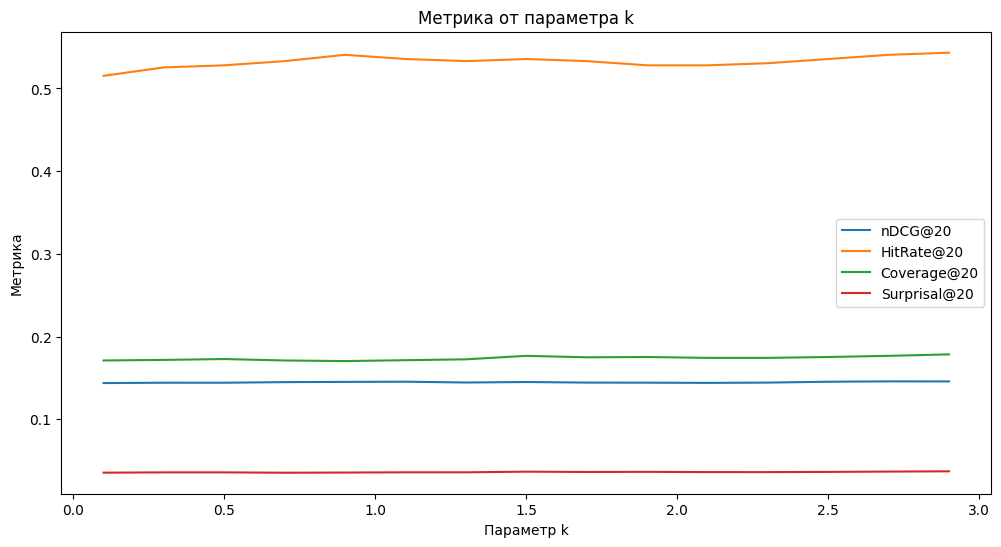

In [468]:
plt.figure(figsize=(12,6))
plt.plot(params_k, nDCG_rate, label = f'nDCG@{K}')
plt.plot(params_k, HitRate_rate, label = f'HitRate@{K}')
plt.plot(params_k, Coverage_rate, label = f'Coverage@{K}')
plt.plot(params_k, Surprisal_rate, label = f'Surprisal@{K}')
plt.xlabel('Параметр k')
plt.ylabel('Метрика')
plt.legend()
plt.title('Метрика от параметра k')
plt.show()

Как мы видим - параметр k особо не влияет. Возьмем 1.

In [469]:
def cosine_recommendations_bm25_b(param_b):
    model = CosineRecommender(K=10)
    model.fit(bm25_weight(csr_train, K1=1, B=param_b))

    cosine_pred_bm25 = []
    for user_id in val["user_id"].unique():
        items, scores = model.recommend(user_id, csr_train[user_id], N=K)
        for item, score in zip(items, scores):
            cosine_pred_bm25.append((user_id, item, score))
    columns = ['user_id', 'item_id', 'relevance']
    cosine_pred_bm25 = pd.DataFrame(cosine_pred_bm25, columns=columns)
    return cosine_pred_bm25

In [470]:
params_b = np.arange(0.1, 1.1, 0.1)
nDCG_rate = []
HitRate_rate = []
Coverage_rate = []
Surprisal_rate = []

for param_b in params_b:
    cosine_pred = cosine_recommendations_bm25_b(param_b)
    metrics = evaluate_metrics(cosine_pred, val, k=K)
    nDCG_rate.append(metrics[f'nDCG@{K}'])
    HitRate_rate.append(metrics[f'HitRate@{K}'])
    Coverage_rate.append(metrics[f'Coverage@{K}'])
    Surprisal_rate.append(metrics[f'Surprisal@{K}'])

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008158445358276367 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0074079036712646484 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006203651428222656 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006659030914306641 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006438732147216797 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006429195404052734 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007996320724487305 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006400585174560547 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006460905075073242 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006425142288208008 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

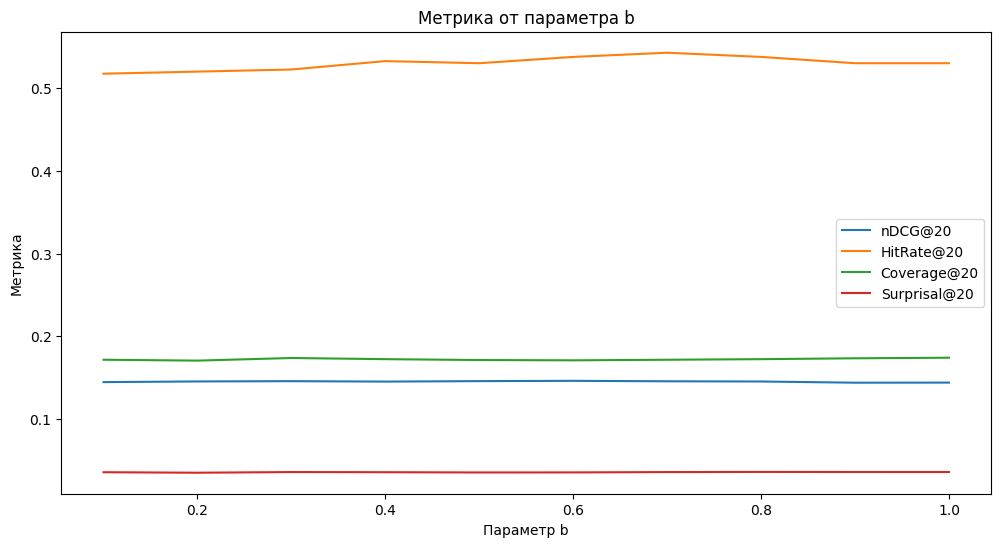

In [471]:
plt.figure(figsize=(12,6))
plt.plot(params_b, nDCG_rate, label = f'nDCG@{K}')
plt.plot(params_b, HitRate_rate, label = f'HitRate@{K}')
plt.plot(params_b, Coverage_rate, label = f'Coverage@{K}')
plt.plot(params_b, Surprisal_rate, label = f'Surprisal@{K}')
plt.xlabel('Параметр b')
plt.ylabel('Метрика')
plt.legend()
plt.title('Метрика от параметра b')
plt.show()

Параметр b - возьмем равным 0.5

In [472]:
%%time

model = CosineRecommender(K=20)
model.fit(bm25_weight(csr_train, K1=1, B=0.5))

cosine_pred_bm25 = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred_bm25.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred_bm25 = pd.DataFrame(cosine_pred_bm25, columns=columns)

metric_dict_cosine_bm25 = evaluate_metrics(cosine_pred_bm25, val, k=K)
print("cosine bm25")
for key, item in metric_dict_cosine_bm25.items():
    print(f"{key} : {item}")

print()

model = CosineRecommender(K=20)
model.fit(csr_train)

cosine_pred = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred = pd.DataFrame(cosine_pred, columns=columns)

metric_dict_cosine = evaluate_metrics(cosine_pred, val, k=K)
print("cosine")
for key, item in metric_dict_cosine.items():
    print(f"{key} : {item}")

print()

random_pred = []
for user_id in val['user_id'].unique():
    recommended_items = np.random.choice(reviews['item_id'].unique(), size=K, replace=False)
    for item in recommended_items:
        random_pred.append((user_id, item, np.random.randint(5) + 1))

columns = ['user_id', 'item_id', 'relevance']
random_pred = pd.DataFrame(random_pred, columns=columns)

metric_dict = evaluate_metrics(random_pred, val, k=K)
print("random")
for key, item in metric_dict.items():
    print(f"{key} : {item}")

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006530284881591797 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine bm25
nDCG@20 : 0.15264641871112616
HitRate@20 : 0.5203045685279187
Coverage@20 : 0.1446629213483146
Surprisal@20 : 0.02839547879208949



/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006676197052001953 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine
nDCG@20 : 0.15238065301186973
HitRate@20 : 0.5177664974619289
Coverage@20 : 0.1408005617977528
Surprisal@20 : 0.027580007688718426

random
nDCG@20 : 0.015318056261157911
HitRate@20 : 0.16751269035532995
Coverage@20 : 0.8837780898876404
Surprisal@20 : 0.3326614414900701
CPU times: user 10.9 s, sys: 37.7 ms, total: 11 s
Wall time: 10.1 s


Увеличение небольшое увеличнеие метрик.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

In [473]:
train = reviews[reviews['timestamp'] < '2000-12-01']
val = reviews[(reviews['timestamp'] >= '2000-12-01') & (reviews['timestamp'] < '2000-12-15') & (reviews['relevance'] > 3)]
test = reviews[(reviews['timestamp'] >= '2000-12-15') & (reviews['timestamp'] <= '2000-12-31') & (reviews['relevance'] > 3)]
cold_guys_val = set(val['user_id']) - set(train['user_id'])
val = val[~val['user_id'].isin(cold_guys_val)]
cold_guys_test = set(test['user_id']) - set(train['user_id'])
test = test[~test['user_id'].isin(cold_guys_test)]
train = train[['user_id', 'item_id', 'relevance']]
val = val[['user_id', 'item_id', 'relevance']]
test = test[['user_id', 'item_id', 'relevance']]

train['relevance'] = train['relevance'].astype('float32', copy=False)
csr_train = csr_matrix((train['relevance'].values, (train['user_id'].values, train['item_id'].values)))
val['relevance'] = val['relevance'].astype('float32', copy=False)
csr_val = csr_matrix((val['relevance'].values, (val['user_id'].values, val['item_id'].values)))
val['relevance'] = val['relevance'].astype('float32', copy=False)
csr_test = csr_matrix((test['relevance'].values, (test['user_id'].values, test['item_id'].values)))

<ipython-input-473-f6a7df474760>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['relevance'] = train['relevance'].astype('float32', copy=False)


In [474]:
%%time

model = CosineRecommender(K=20)
model.fit(bm25_weight(csr_train, K1=1, B=0.5))

cosine_pred_bm25 = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred_bm25.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred_bm25 = pd.DataFrame(cosine_pred_bm25, columns=columns)

metric_dict_cosine_bm25 = evaluate_metrics(cosine_pred_bm25, val, k=K)
print("cosine bm25")
for key, item in metric_dict_cosine_bm25.items():
    print(f"{key} : {item}")

print()

model = CosineRecommender(K=20)
model.fit(csr_train)

cosine_pred = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred = pd.DataFrame(cosine_pred, columns=columns)

metric_dict_cosine = evaluate_metrics(cosine_pred, val, k=K)
print("cosine")
for key, item in metric_dict_cosine.items():
    print(f"{key} : {item}")

print()

random_pred = []
for user_id in val['user_id'].unique():
    recommended_items = np.random.choice(reviews['item_id'].unique(), size=K, replace=False)
    for item in recommended_items:
        random_pred.append((user_id, item, np.random.randint(5) + 1))

columns = ['user_id', 'item_id', 'relevance']
random_pred = pd.DataFrame(random_pred, columns=columns)

metric_dict = evaluate_metrics(random_pred, val, k=K)
print("random")
for key, item in metric_dict.items():
    print(f"{key} : {item}")

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006143093109130859 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine bm25
nDCG@20 : 0.13364860227047493
HitRate@20 : 0.5013774104683195
Coverage@20 : 0.18127853881278538
Surprisal@20 : 0.03467953264558977



/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006047964096069336 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine
nDCG@20 : 0.13566826486259295
HitRate@20 : 0.512396694214876
Coverage@20 : 0.1771689497716895
Surprisal@20 : 0.033485448406943584

random
nDCG@20 : 0.009608856236857095
HitRate@20 : 0.11570247933884298
Coverage@20 : 0.8547945205479452
Surprisal@20 : 0.3886033532161633
CPU times: user 10.2 s, sys: 41 ms, total: 10.2 s
Wall time: 8.72 s


Две метрики чуть-чуть поменьше, а другие две метрики чуть-чуть побольше.

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.


In [475]:
train = reviews[reviews['timestamp'] < '2000-12-01']
val = reviews[(reviews['timestamp'] >= '2000-12-01') & (reviews['timestamp'] < '2000-12-15')]
test = reviews[(reviews['timestamp'] >= '2000-12-15') & (reviews['timestamp'] <= '2000-12-31')]
cold_guys_val = set(val['user_id']) - set(train['user_id'])
val = val[~val['user_id'].isin(cold_guys_val)]
cold_guys_test = set(test['user_id']) - set(train['user_id'])
test = test[~test['user_id'].isin(cold_guys_test)]
train = train[['user_id', 'item_id', 'relevance']]
val = val[['user_id', 'item_id', 'relevance']]
test = test[['user_id', 'item_id', 'relevance']]

train['relevance'] = train['relevance'].astype('float32', copy=False)
csr_train = csr_matrix((train['relevance'].values, (train['user_id'].values, train['item_id'].values)))
val['relevance'] = val['relevance'].astype('float32', copy=False)
csr_val = csr_matrix((val['relevance'].values, (val['user_id'].values, val['item_id'].values)))
val['relevance'] = val['relevance'].astype('float32', copy=False)
csr_test = csr_matrix((test['relevance'].values, (test['user_id'].values, test['item_id'].values)))

<ipython-input-475-b289b02810c8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['relevance'] = train['relevance'].astype('float32', copy=False)
<ipython-input-475-b289b02810c8>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['relevance'] = val['relevance'].astype('float32', copy=False)
<ipython-input-475-b289b02810c8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [476]:
%%time

model = AlternatingLeastSquares(factors=5)
model.fit(csr_train)

least_squares = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        least_squares.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
least_squares = pd.DataFrame(least_squares, columns=columns)

metric_dict_least_squares = evaluate_metrics(least_squares, val, k=K)
print("least squares")
for key, item in metric_dict_least_squares.items():
    print(f"{key} : {item}")

print()

model = CosineRecommender(K=20)
model.fit(bm25_weight(csr_train, K1=1, B=0.5))

cosine_pred_bm25 = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred_bm25.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred_bm25 = pd.DataFrame(cosine_pred_bm25, columns=columns)

metric_dict_cosine_bm25 = evaluate_metrics(cosine_pred_bm25, val, k=K)
print("cosine bm25")
for key, item in metric_dict_cosine_bm25.items():
    print(f"{key} : {item}")

print()

model = CosineRecommender(K=20)
model.fit(csr_train)

cosine_pred = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred = pd.DataFrame(cosine_pred, columns=columns)

metric_dict_cosine = evaluate_metrics(cosine_pred, val, k=K)
print("cosine")
for key, item in metric_dict_cosine.items():
    print(f"{key} : {item}")

print()

random_pred = []
for user_id in val['user_id'].unique():
    recommended_items = np.random.choice(reviews['item_id'].unique(), size=K, replace=False)
    for item in recommended_items:
        random_pred.append((user_id, item, np.random.randint(5) + 1))

columns = ['user_id', 'item_id', 'relevance']
random_pred = pd.DataFrame(random_pred, columns=columns)

metric_dict = evaluate_metrics(random_pred, val, k=K)
print("random")
for key, item in metric_dict.items():
    print(f"{key} : {item}")

  0%|          | 0/15 [00:00<?, ?it/s]

least squares
nDCG@20 : 0.16004359727296422
HitRate@20 : 0.5532994923857868
Coverage@20 : 0.19487359550561797
Surprisal@20 : 0.03784026236532295



/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0064852237701416016 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine bm25
nDCG@20 : 0.15264641871112616
HitRate@20 : 0.5203045685279187
Coverage@20 : 0.1446629213483146
Surprisal@20 : 0.02839547879208949



/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0067653656005859375 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine
nDCG@20 : 0.15238065301186973
HitRate@20 : 0.5177664974619289
Coverage@20 : 0.1408005617977528
Surprisal@20 : 0.027580007688718426

random
nDCG@20 : 0.01735162746872044
HitRate@20 : 0.20050761421319796
Coverage@20 : 0.8774578651685393
Surprisal@20 : 0.3317740142820119
CPU times: user 32.1 s, sys: 25.7 s, total: 57.8 s
Wall time: 36.7 s


In [477]:
def least_squares_recommendations(factors):
    model = AlternatingLeastSquares(factors=factors)
    model.fit(csr_train)

    cosine_pred = []
    for user_id in val["user_id"].unique():
        items, scores = model.recommend(user_id, csr_train[user_id], N=K)
        for item, score in zip(items, scores):
            cosine_pred.append((user_id, item, score))
    columns = ['user_id', 'item_id', 'relevance']
    cosine_pred = pd.DataFrame(cosine_pred, columns=columns)
    return cosine_pred

In [478]:
factors = np.arange(1, 21, 2)
nDCG_rate = []
HitRate_rate = []
Coverage_rate = []
Surprisal_rate = []

for factor in factors:
    cosine_pred = least_squares_recommendations(factor)
    metrics = evaluate_metrics(cosine_pred, val, k=K)
    nDCG_rate.append(metrics[f'nDCG@{K}'])
    HitRate_rate.append(metrics[f'HitRate@{K}'])
    Coverage_rate.append(metrics[f'Coverage@{K}'])
    Surprisal_rate.append(metrics[f'Surprisal@{K}'])

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

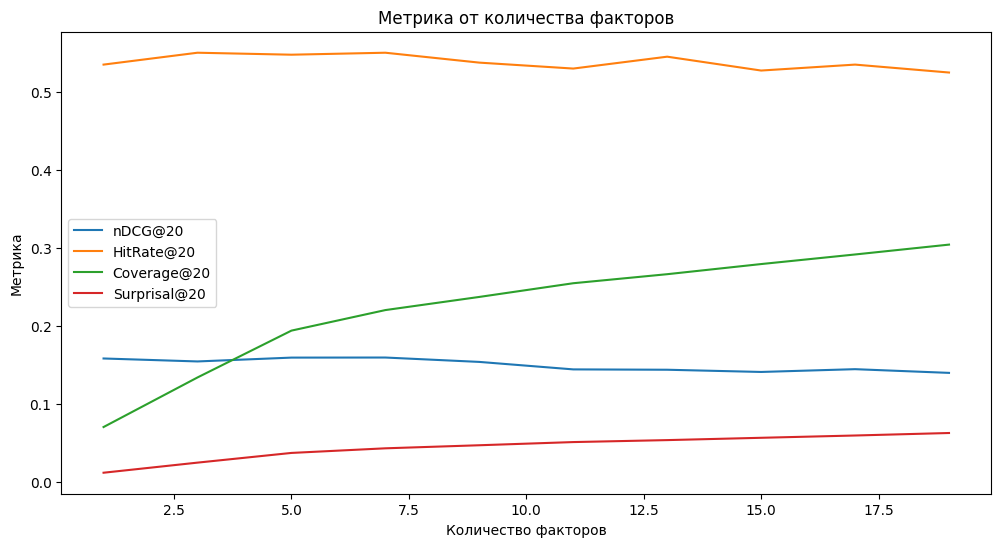

In [479]:
plt.figure(figsize=(12,6))
plt.plot(factors, nDCG_rate, label = f'nDCG@{K}')
plt.plot(factors, HitRate_rate, label = f'HitRate@{K}')
plt.plot(factors, Coverage_rate, label = f'Coverage@{K}')
plt.plot(factors, Surprisal_rate, label = f'Surprisal@{K}')
plt.xlabel('Количество факторов')
plt.ylabel('Метрика')
plt.legend()
plt.title('Метрика от количества факторов')
plt.show()

Как мы видим - лучшее значение 10.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

In [480]:
train = reviews[reviews['timestamp'] < '2000-12-01']
val = reviews[(reviews['timestamp'] >= '2000-12-01') & (reviews['timestamp'] < '2000-12-15') & (reviews['relevance'] > 3)]
test = reviews[(reviews['timestamp'] >= '2000-12-15') & (reviews['timestamp'] <= '2000-12-31') & (reviews['relevance'] > 3)]
cold_guys_val = set(val['user_id']) - set(train['user_id'])
val = val[~val['user_id'].isin(cold_guys_val)]
cold_guys_test = set(test['user_id']) - set(train['user_id'])
test = test[~test['user_id'].isin(cold_guys_test)]
train = train[['user_id', 'item_id', 'relevance']]
val = val[['user_id', 'item_id', 'relevance']]
test = test[['user_id', 'item_id', 'relevance']]

train['relevance'] = train['relevance'].astype('float32', copy=False)
csr_train = csr_matrix((train['relevance'].values, (train['user_id'].values, train['item_id'].values)))
val['relevance'] = val['relevance'].astype('float32', copy=False)
csr_val = csr_matrix((val['relevance'].values, (val['user_id'].values, val['item_id'].values)))
val['relevance'] = val['relevance'].astype('float32', copy=False)
csr_test = csr_matrix((test['relevance'].values, (test['user_id'].values, test['item_id'].values)))

<ipython-input-480-f6a7df474760>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['relevance'] = train['relevance'].astype('float32', copy=False)
<ipython-input-480-f6a7df474760>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['relevance'] = val['relevance'].astype('float32', copy=False)
<ipython-input-480-f6a7df474760>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [481]:
%%time

model = AlternatingLeastSquares(factors=10)
model.fit(csr_train)

least_squares = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        least_squares.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
least_squares = pd.DataFrame(least_squares, columns=columns)

metric_dict_least_squares = evaluate_metrics(least_squares, val, k=K)
print("least squares")
for key, item in metric_dict_least_squares.items():
    print(f"{key} : {item}")

print()

model = CosineRecommender(K=20)
model.fit(bm25_weight(csr_train, K1=1, B=0.5))

cosine_pred_bm25 = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred_bm25.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred_bm25 = pd.DataFrame(cosine_pred_bm25, columns=columns)

metric_dict_cosine_bm25 = evaluate_metrics(cosine_pred_bm25, val, k=K)
print("cosine bm25")
for key, item in metric_dict_cosine_bm25.items():
    print(f"{key} : {item}")

print()

model = CosineRecommender(K=20)
model.fit(csr_train)

cosine_pred = []
for user_id in val["user_id"].unique():
    items, scores = model.recommend(user_id, csr_train[user_id], N=K)
    for item, score in zip(items, scores):
        cosine_pred.append((user_id, item, score))
columns = ['user_id', 'item_id', 'relevance']
cosine_pred = pd.DataFrame(cosine_pred, columns=columns)

metric_dict_cosine = evaluate_metrics(cosine_pred, val, k=K)
print("cosine")
for key, item in metric_dict_cosine.items():
    print(f"{key} : {item}")

print()

random_pred = []
for user_id in val['user_id'].unique():
    recommended_items = np.random.choice(reviews['item_id'].unique(), size=K, replace=False)
    for item in recommended_items:
        random_pred.append((user_id, item, np.random.randint(5) + 1))

columns = ['user_id', 'item_id', 'relevance']
random_pred = pd.DataFrame(random_pred, columns=columns)

metric_dict = evaluate_metrics(random_pred, val, k=K)
print("random")
for key, item in metric_dict.items():
    print(f"{key} : {item}")

  0%|          | 0/15 [00:00<?, ?it/s]

least squares
nDCG@20 : 0.13564585404821342
HitRate@20 : 0.5261707988980716
Coverage@20 : 0.30319634703196346
Surprisal@20 : 0.058152344991344425



/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006954193115234375 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine bm25
nDCG@20 : 0.13364860227047493
HitRate@20 : 0.5013774104683195
Coverage@20 : 0.18127853881278538
Surprisal@20 : 0.03467953264558977



/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00717616081237793 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

cosine
nDCG@20 : 0.13566826486259295
HitRate@20 : 0.512396694214876
Coverage@20 : 0.1771689497716895
Surprisal@20 : 0.033485448406943584

random
nDCG@20 : 0.009334055608072843
HitRate@20 : 0.12121212121212122
Coverage@20 : 0.8821917808219178
Surprisal@20 : 0.38893774733042435
CPU times: user 32.9 s, sys: 27.4 s, total: 1min
Wall time: 39 s


Как мы видим, все метрики улучшились.

# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.

Лучше всего себя показала ALS при хорошем подборе количества факторов. При хорошей настроке весов bm25 получилось чуть-чуть улучшить метрики по сравнению с CosineRecommender, но они все еще проигрывают ALS. Фильтрация данных по релеватности особо не помогло.

У меня вечно все падало по непонятным причинам, а ответы на вопросы было очень тяжело найти.